## Pathways

Analyze the pathways in two different selection models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
from scipy.sparse import dok_matrix, csr_matrix
from sklearn.preprocessing import normalize
import networkx as nx
import itertools
from itertools import islice
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
import scipy as sp
import math
import csv
from collections import OrderedDict
import sys
import matplotlib.cm as cm
import matplotlib.colors as colors



mpl.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 7,'axes.linewidth':0.5,
                     'xtick.major.size':2,'xtick.major.width':0.5,
                    'ytick.major.size':2,'ytick.major.width':0.5})
plt.rcParams.update({'mathtext.default':  'regular' })

L = 15
sequences_int = range(2**L)
Nbootstrap=10


# define some functions
def mutation(s, ii, L):
    """ Return the sequence (in int format) with base s,
        with a somatic mutation at pos ii """
    return s | int(2**(L-1-ii))

def mutation_diff(ii, jj):
    return (ii ^ jj).bit_length()

def nb_mutation(s):
    """ Number of mutations in variant s """
    return bin(s).count("1")

def reachable(s, L):
    return [(s | 2**ii) for ii in range(L) if (s | 2**ii) > s]

def k_shortest_paths(G, source, target, k, weight=None):
    return list(
        islice(nx.shortest_simple_paths(G, source, target, weight=weight), k)
    )
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap



## Load data

In [3]:
FILENAME = '../../Titeseq/results/Kds/cleaned_Kds_RBD_ACE2.tsv'
df = pd.read_csv(FILENAME,
                 dtype={"geno":"str"}, sep="\t")
df["geno_int"] = df.geno.apply(lambda x: int(x, 2))

df = df.set_index("geno_int").reindex(range(0, 2**L)).reset_index()
sequences_int = range(0,2**L)
for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'

mutation_names = ['G339D','S371L','S373P','S375F',
                  'K417N',
                  'N440K',
                  'G446S',
                  'S477N','T478K',
                  'E484A',
                  'Q493R',
                  'G496S',
                  'Q498R','N501Y','Y505H'
                 ]

colors = ["#66c2bd", "#1b9d9b", "#fc7864", "#d94602", "#8DA0CB","#7570B3","#E78AC3","#E7298A","#A6D854","#66A61E","#FFD92F","#E6AB02","#E5C494","#A6761D","#B3B3B3","#666666"]
fitness = (df[f"log10Kd"]).values.astype('float32')

#fitness = (df[f"log10Kd"]).values.astype('float32')
fitnesses = df[f"log10Kd"].values.astype('float32')


In [4]:
def fixation_probability_moderate(fitness_s,fitness_t,Npop,gamma):
    if np.isnan(fitness_s) or np.isnan(fitness_t):
        pval = 0.0
    else:
        delta = fitness_t - fitness_s
        if delta == 0.0:
            pval = 1.0/Npop
        elif Npop*gamma*delta > -100:
            pval = ((1 - np.exp(-gamma*delta))/(1 - np.exp(-Npop*gamma*delta)))
        else:
            pval = 0
    return pval   

In [5]:
# Calculate normalized transition matrices 

pmut_unnormed = dok_matrix((2**L, 2**L), dtype=np.float64)

for s in sequences_int:
    for t in reachable(s, L):
        if t in sequences_int:
            pmut_unnormed[s, t] = fixation_probability_moderate(fitnesses[s],fitnesses[t], 1000, 0.1)                

### change format for something that can deal with multiplications
pmut_unnormed.tocsr()
### normalize the sparse matrix
pmut_normed = normalize(pmut_unnormed, norm='l1', axis=1)

## precompute the transition probability matrix to every power
pmut_power = {}
for i in range(L):
    pmut_power[i] = pmut_normed**i

## compute the matrix that force the mutation to be mut
force_mut = {}
for mut in range(L):
    for i in range(L):
        force_mut[(i,mut)] = dok_matrix((2**L, 2**L), dtype=np.float64)
    
    for s in sequences_int[:-1]:
        nb_mut = nb_mutation(s)
        t = mutation(s, mut, L)
        force_mut[(nb_mut,mut)][s, t] = pmut_normed[s, t]


maxmut = 15
sequences_int_fixedmut = [s for s in sequences_int if nb_mutation(s) == maxmut]

end = int('111111111111111', 2)

## compute probabilities
proba = np.zeros((L, maxmut))
for mut in range(L):
    for t in range(1, maxmut+1):
        proba[mut, t-1] = (pmut_power[t-1] @ force_mut[(t-1,mut)] @ pmut_power[maxmut - t])[0, end]


In [6]:
dfplot = pd.DataFrame()
dfplot["Order"] = range(maxmut)
dfplot = dfplot.set_index("Order")
for ii, mm in enumerate(mutation_names):
    dfplot[f"{mm}"] = [proba[ii, k] for k in range(maxmut)]
dfplot = dfplot.stack().reset_index().rename({'level_1': "Mutation", 0: "Proportion"}, axis=1)

In [7]:
reordered_mutations = [0,1,2,3,5,7,8,10,12,13,4,6,9,11,14]
reordered_mutation_names = ['G339D', 'S371L', 'S373P', 'S375F', 'N440K', 'S477N', 'T478K', 'Q493R', 'Q498R', 'N501Y', 'K417N', 'G446S', 'E484A', 'G496S', 'Y505H']

mutations_not_in_BA2 = []

def plot_order_barplots(proba, order=reordered_mutations, exclude_mutations=mutations_not_in_BA2, title='', label_xpos=0.85):
    maxmut = L - len(exclude_mutations)

    fig, axes = plt.subplots(5, 3, figsize=(8, 4), sharex=True, sharey=True)
    for i, ax in enumerate(axes.T.flatten()):
        m = reordered_mutations[i]
        label = mutation_names[m]
        
        ax.text(label_xpos - 0.2, 0.85, label, ha='center', va='top', transform=ax.transAxes, fontsize=10, 
                #color='k' if i < 10 else 'r'
                color=colors[i]
                )
        if i % 5 == 4:
            ax.set_xlabel('Mutation order')
        if i == 2:
            ax.set_ylabel('Likelihood')
        #if i >= 10:
        #    for side in ['left', 'right', 'top', 'bottom']:
        #        ax.spines[side].set_color('red')
            
        if label in exclude_mutations:
            ax.set_facecolor('lightgray')
            continue
            
        ax.bar(range(maxmut), proba[m,:], color=colors[i], label=label, edgecolor='k', 
               linewidth=0.5, width=1.0)
        ax.set_xticks(range(L))
        ax.set_xticklabels(range(1,L+1))
        ax.set_yticks([])


    fig.suptitle(title, fontsize=10, y=0.92)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    return fig, axes

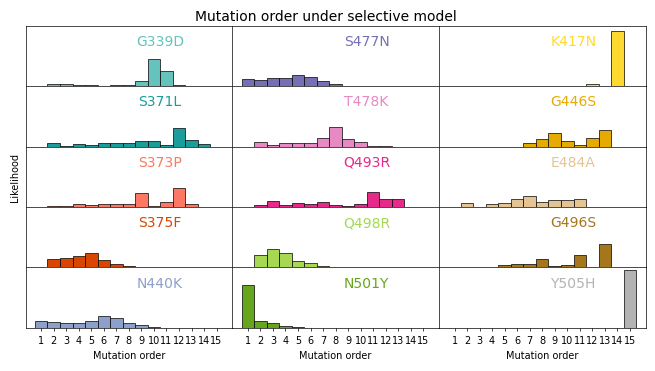

In [8]:
dfsave = pd.DataFrame(proba.T, columns=[m for m in mutation_names] , index=[f"pos{i}" for i in range(1, 16)])
dfsave.to_csv("../Figures/data/proba_order_strong_selection_noBA2.csv")
plot_order_barplots(proba, title='Mutation order under selective model');

## Pathways that stay above Wuhan Kd

In [9]:
KD_CUTOFF_DIFF = 0
END = int('101111011110111', 2)
maxmut = 12 #should be the # of 1's in END
mutations_not_in_BA2 = ['S371L', 'G446S', 'G496S']
## compute probabilities

pmut_unnormed = dok_matrix((2**L, 2**L), dtype=np.float64)

for s in sequences_int:
    for t in reachable(s, L):
        pmut_unnormed[s, t] = 1 #fixation_probability_moderate(fitnesses[s],fitnesses[t], 1000, 1)                

        
## compute the matrix that remove the  negative state
noneg = dok_matrix((2**L, 2**L), dtype=np.float64)
for s in sequences_int:
    if fitness[s] >= fitness[0] - KD_CUTOFF_DIFF:
        noneg[s, s] = 1
    else:
        noneg[s, s] = 0
### change format for something that can deal with multiplications
# pmut_unnormed.tocsr()
### normalize the sparse matrix
pmut_normed = normalize(pmut_unnormed, norm='l1', axis=1)
pmut_normed_noneg = normalize(noneg@pmut_unnormed@noneg, norm='l1', axis=1)

## precompute the transition probability matrix to every power
pmut_power = {}
for i in range(L):
    pmut_power[i] = pmut_normed_noneg**i
    
            
## compute the matrix that force the mutation to be mut
force_mut = {}
for mut in range(L):
    for i in range(L):
        force_mut[(i,mut)] = dok_matrix((2**L, 2**L), dtype=np.float64)
    
    for s in sequences_int[:-1]:
        nb_mut = nb_mutation(s)
        t = mutation(s, mut, L)
        force_mut[(nb_mut,mut)][s, t] =  pmut_normed_noneg[s, t]

## compute probabilities
proba = np.zeros((L, maxmut))
for mut in range(L):
    for t in range(1, maxmut+1):
        proba[mut, t-1] = (pmut_power[t-1] @ force_mut[(t-1,mut)] @ pmut_power[maxmut - t])[0, END]

In [10]:
dfsave = pd.DataFrame(proba.T, columns=[m for m in mutation_names] , index=[f"pos{i}" for i in range(1, 13)])
dfsave.to_csv("../Figures/data/proba_order_mut_above_wuhan.csv")

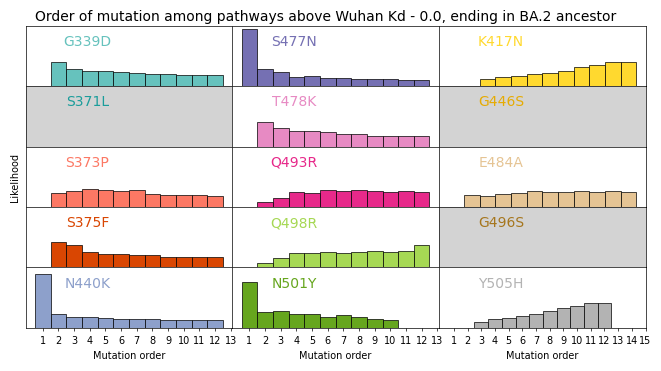

In [11]:
plot_order_barplots(proba, exclude_mutations=mutations_not_in_BA2,
                    title='Order of mutation among pathways above Wuhan Kd - %.1f, ending in BA.2 ancestor' % KD_CUTOFF_DIFF,
                    label_xpos = 0.5);

In [14]:
df.log10Kd.min()

6.875571895023276